In [109]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [110]:
def f1(x1,y1):
    return (x1**2+y1-11)**2+(x1+y1**2-7)**2
def f2(x2,y2):
    return 2*x2**2+1.05*x2**4+(x2**6)/6+x2*y2+y2**2

def sumF1F2(individual):
    x1,y1,x2,y2 = individual
    return f1(x1,y1)+f2(x2,y2)

In [111]:
def getPlotVariables(minVariable, maxVariable, function):
    x = np.linspace(minVariable, maxVariable, 100)
    y = x.copy()
    X, Y = np.meshgrid(x, y)
    Z = function(X, Y)
    return X, Y, Z

In [112]:
def draw2DPlot(X,Y,Z,bestPoint=None, additionalPoints=None):

    plt.contourf(X,Y,Z, levels=20, colors='white')
    contour = plt.contour(X,Y,Z, levels=10, colors='black')
    plt.clabel(contour, inline=1, fontsize=8)

    if bestPoint is not None:
        plt.plot(bestPoint[0], bestPoint[1], 'ro')
    if additionalPoints is not None:
        plt.scatter(additionalPoints[:,0], additionalPoints[:,1],marker='.',s=30)
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

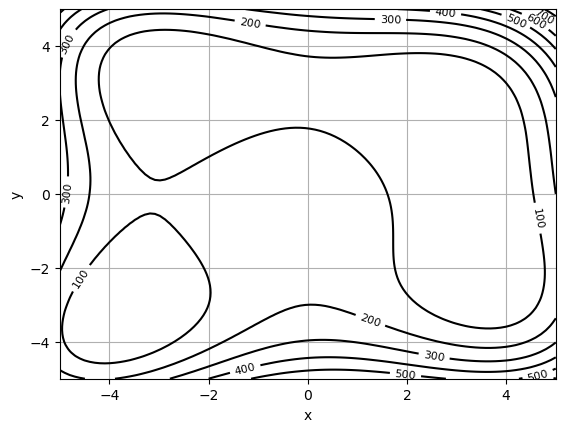

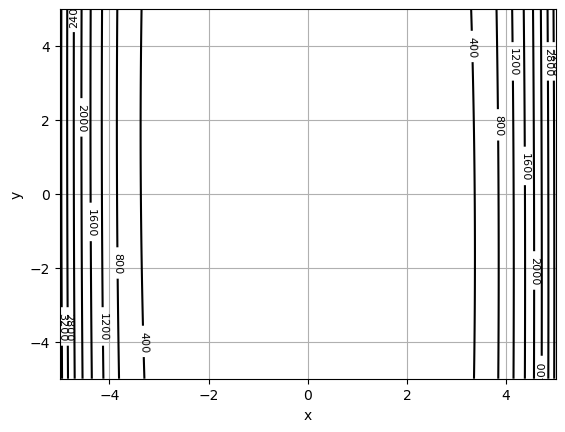

In [113]:
X1,Y1,Z1 = getPlotVariables(-5,5,f1)
draw2DPlot(X1,Y1,Z1)


X2,Y2,Z2 = getPlotVariables(-5,5,f2)
draw2DPlot(X2,Y2,Z2)

In [114]:
def gaussMutation(individual, sigma):
    mutatedIndividual = np.zeros(len(individual))
    for i in range(len(individual)):
        mutatedIndividual[i] = individual[i] + np.random.normal(0, sigma)
    return mutatedIndividual


In [115]:
def mutatePopulation(population, sigma):
    mutatedPopulation = []
    for individual in population:
        individual1 = gaussMutation(individual, sigma)
        mutatedPopulation.append(individual1)
    return mutatedPopulation

In [116]:
def individualSinglePointCrossBreeding(individual1, individual2):
    point = random.randint(0, len(individual1)-1)
    return np.concatenate((individual1[:point], individual2[point:]), axis=None)

In [117]:
def populationCrossBreeding(population, crossingProbability):
    random.shuffle(population)
    crossedPopulation = []
    for i in range(0, len(population), 2):
        if random.random() < crossingProbability:
            crossedPopulation.append(individualSinglePointCrossBreeding(population[i], population[i+1]))
            crossedPopulation.append(individualSinglePointCrossBreeding(population[i+1], population[i]))
        else:
            crossedPopulation.append(population[i])
            crossedPopulation.append(population[i+1])
    return crossedPopulation

In [118]:
def generateRandomPopulation(size, D):
    return [np.random.uniform(D[0], D[1], 4) for _ in range(size)]


In [119]:
def isOutOfRange(individual, D):
    return individual[0] <= D[0] or individual[0] >= D[1] or individual[1] <= D[0] or individual[1] >= D[1] or individual[2] <= D[0] or individual[2] >= D[1] or individual[3] <= D[0] or individual[3] >= D[1]

In [120]:
def gradeIndividual(individual,D):
    # if isOutOfRange(individual, D):
    #     # return 99999 * D[1] - np.absolute(sumF1F2(individual))
    #     return 1000
    return sumF1F2(individual)

In [121]:
def gradePopulation(population,D):
    sum = 0
    for individual in population:
        sum += gradeIndividual(individual,D)
    return sum

In [122]:
def tournamentSelection(population,D):
    populationAfterSelection = []

    for _ in range(len(population)):
        individual1 = random.choice(population)
        individual2 = random.choice(population)
        if gradeIndividual(individual1,D) < gradeIndividual(individual2,D):
            populationAfterSelection.append(individual1)
        else:
            populationAfterSelection.append(individual2)
    return populationAfterSelection


In [123]:
def bringIndividualToBoundres(individual, D):
    for i in range(len(individual)):
        individual[i] = max(D[0], min(D[1], individual[i]))
    # individual[0] = max(D[0], min(D[1], individual[0]))
    # individual[1] = max(D[0], min(D[1], individual[1]))
    # individual[2] = max(D[0], min(D[1], individual[2]))
    # individual[3] = max(D[0], min(D[1], individual[3]))
    return individual

In [124]:
def bringPopulationToBoundries(population, D):
    for individual in population:
        individual = bringIndividualToBoundres(individual,D)
    return population

In [125]:
def updateBestIndividual(population, lastBestIndividual,D):
    bestIndividual = lastBestIndividual
    bestValue = gradeIndividual(lastBestIndividual,D)
    for individual in population:
        if gradeIndividual(individual,D) < bestValue:
            bestIndividual = individual
            bestValue = gradeIndividual(individual,D)
    return bestIndividual


In [126]:
def findBestIndividuals(population, numberOfBestIndividual,D):
    # bestIndividuals = []
    # gradeIndividual_fixed = lambda individual: gradeIndividual(individual, D)
    # population.sort(key=gradeIndividual_fixed)
    # population = population[:numberOfBestIndividual]
    # for individual in population:
    #     if not isOutOfRange(individual, D):
    #         bestIndividuals.append(individual)
    # return bestIndividuals
    return sorted(population, key=lambda individual: gradeIndividual(individual, D))[:numberOfBestIndividual]

In [127]:
# def generatePopulationAroundPoint(size, point, D):
#     population = []
#     for _ in range(size):
#         population.append(gaussMutation(point, 1))
#     return population

In [134]:
def generateValuesAroundPoint(size, point,sigma):
    return np.random.normal(point, sigma, (size, 2))

In [129]:
# def generatePopulation

In [130]:
def evolutionAlgorithm(maxIterations,populationSize,crossingProbability,sigma,D,startingPopulation=None):
    epochs = []
    if startingPopulation is None:
        lastPopulation = generateRandomPopulation(populationSize, D)
    else:
        lastPopulation = bringPopulationToBoundries(startingPopulation,D)
    bestIndividual = updateBestIndividual(lastPopulation, lastPopulation[0],D)
    lastPopulationGrade = gradePopulation(lastPopulation,D)
    i = 0
    while i < maxIterations:
        newPopulation = tournamentSelection(lastPopulation,D)
        newPopulation = populationCrossBreeding(newPopulation, crossingProbability)
        newPopulation = mutatePopulation(newPopulation, sigma)
        newPopulation = bringPopulationToBoundries(newPopulation,D)
        bestIndividual = updateBestIndividual(newPopulation, bestIndividual, D)
        newPopulationGrade = gradePopulation(newPopulation,D)
        if newPopulationGrade < lastPopulationGrade:
            lastPopulation = newPopulation
            lastPopulationGrade = newPopulationGrade
        epochs.append(lastPopulation)
        i += 1
    return epochs, bestIndividual

In [131]:
# def evolutionAlgorithm(maxIterations, populationSize, crossingProbability, sigma, D):
#     epochs = []
#     population = generateRandomPopulation(populationSize, D)
#     lastPopulationGrade = 9999999999999
#     # lastPopulation = population
#     bestIndividual = updateBestIndividual(population, population[0],D)
#     i = 0
#     while i < maxIterations:
#         lastPopulation = population
#         population = tournamentSelection(population,D)
#         population = populationCrossBreeding(population, crossingProbability)
#         population = mutatePopulation(population, sigma)
#         bestIndividual = updateBestIndividual(population, bestIndividual,D)
#         thisGrade = gradePopulation(population,D)
#         if lastPopulationGrade < thisGrade and i > 0:
#             population = lastPopulation
#             lastPopulationGrade = gradePopulation(population,D)
#         else:
#             lastPopulationGrade = thisGrade
#         epochs.append(population)
#         i += 1

#     return epochs, bestIndividual


Epoch: 0 Best individual: [ 4.97474221 -3.5395361  -2.87802661  0.67338128], F(bestIndividual)=396.3635791345797


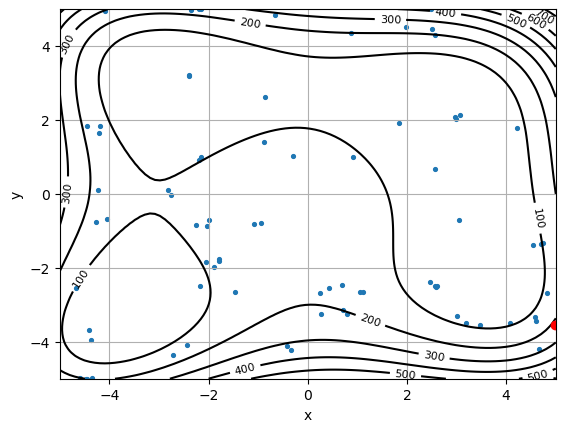

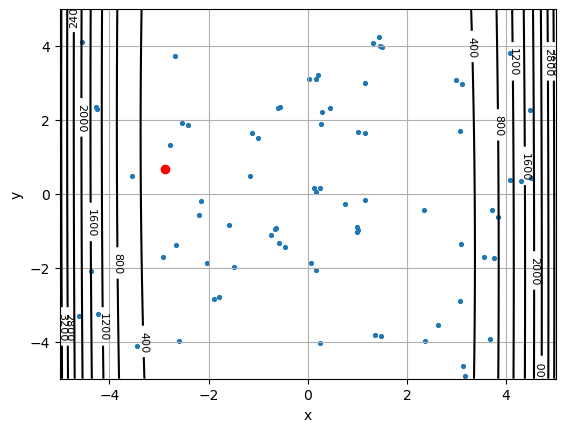

Epoch: 3 Best individual: [ 2.98283038 -1.4603772   0.35288143  0.22554178], F(bestIndividual)=16.643015287146067


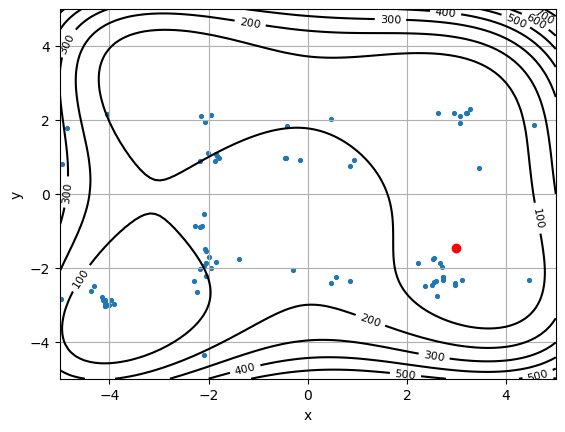

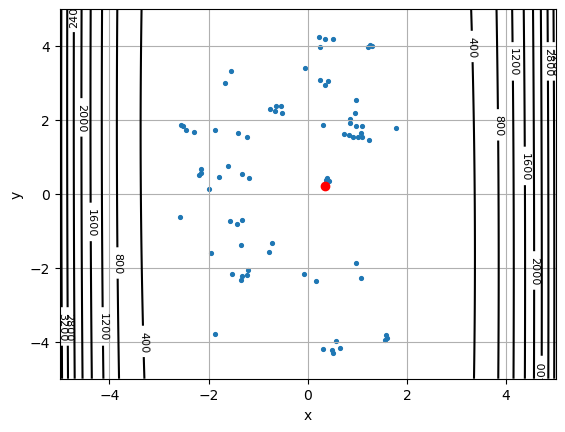

Epoch: 6 Best individual: [ 2.94561382  2.11279575 -1.37436384  0.87676069], F(bestIndividual)=8.422966607991725


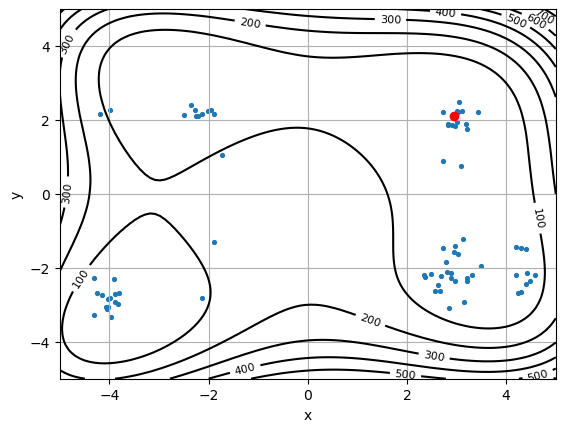

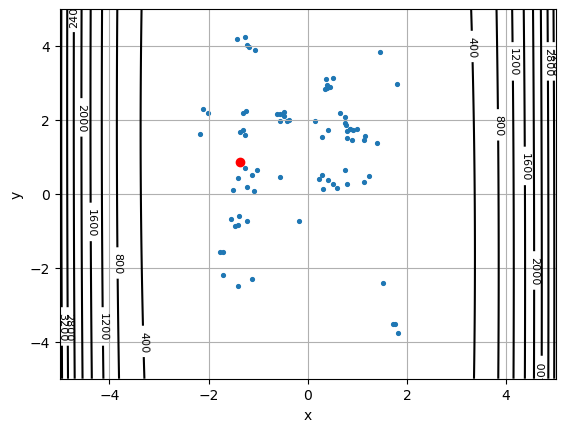

Epoch: 9 Best individual: [ 2.8865833   2.56554395 -1.39478123 -0.06827399], F(bestIndividual)=15.296107594890936


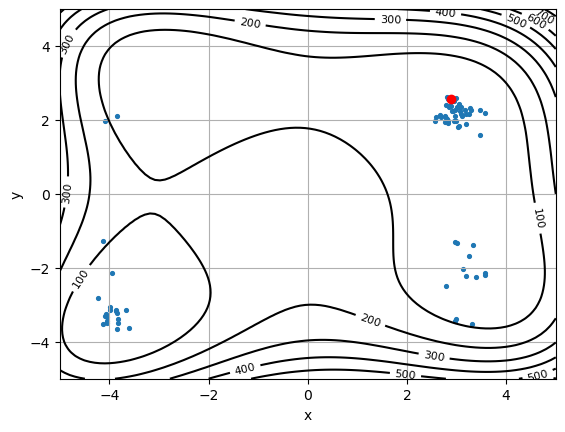

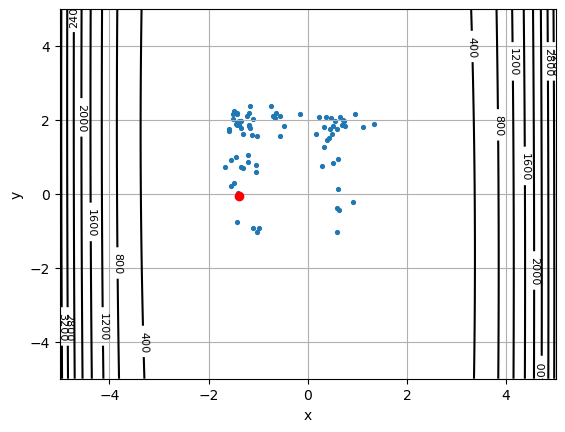

Epoch: 12 Best individual: [-3.61037784 -3.31878116  0.87336241  1.86003923], F(bestIndividual)=9.106312439414703


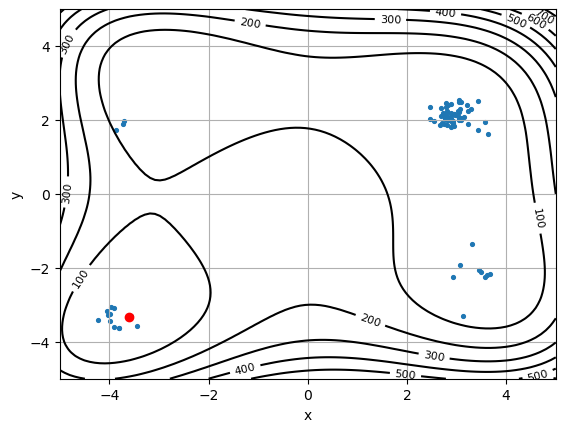

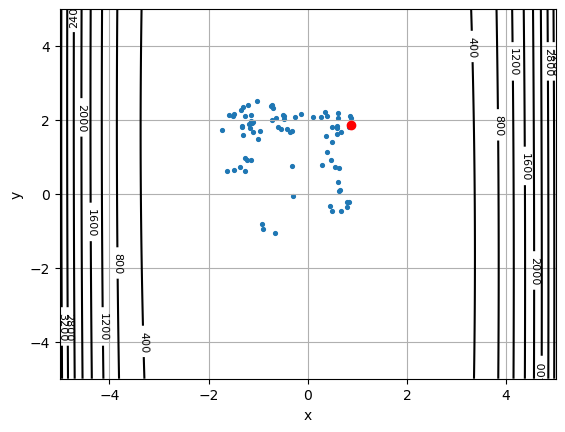

Epoch: 15 Best individual: [ 3.83145193 -2.15955693  0.01165359  0.75186516], F(bestIndividual)=5.121592329377983


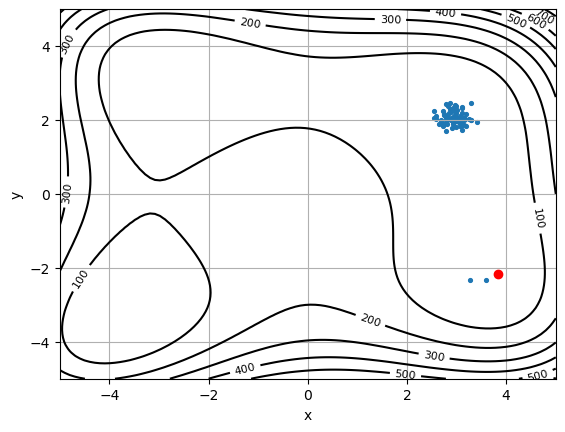

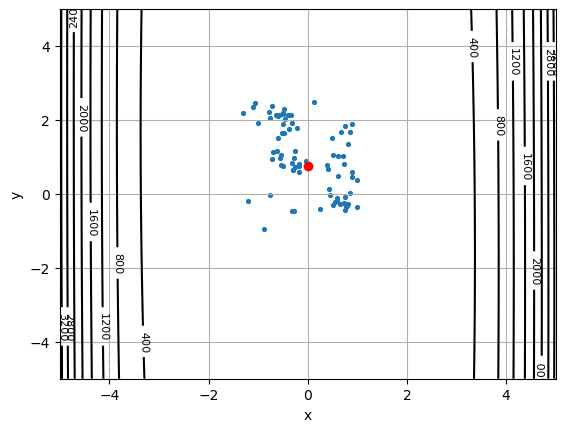

Epoch: 18 Best individual: [2.66543569 1.99254396 0.35200933 0.04341395], F(bestIndividual)=4.035226256934536


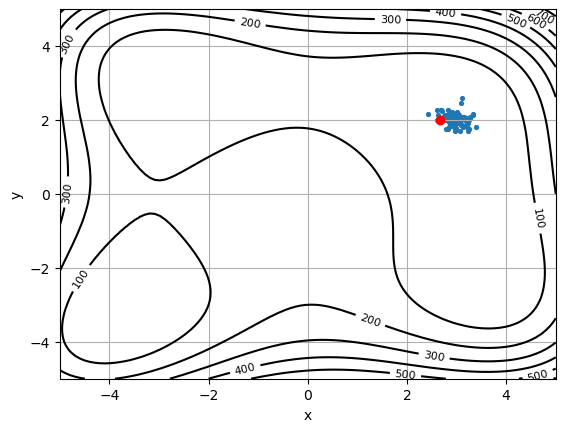

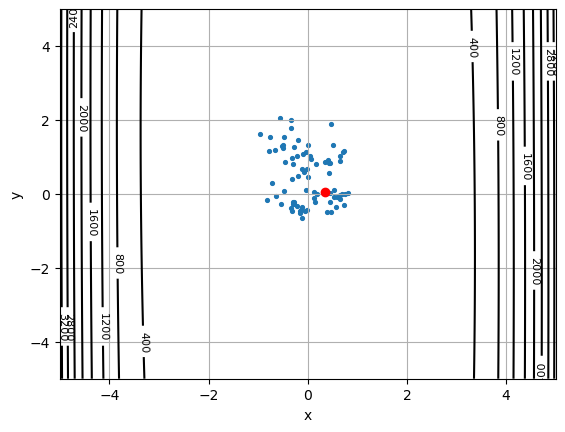

Epoch: 21 Best individual: [ 2.73183197  1.8679529  -0.08516528 -0.22670178], F(bestIndividual)=3.4780111252518466


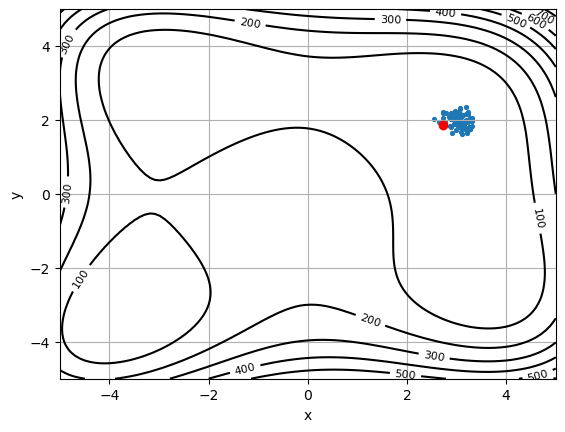

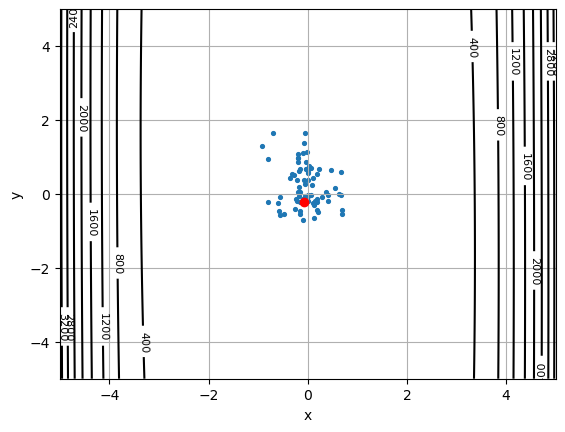

Epoch: 24 Best individual: [ 3.11996455  2.17301282  0.74932146 -0.55687552], F(bestIndividual)=2.9082004313299534


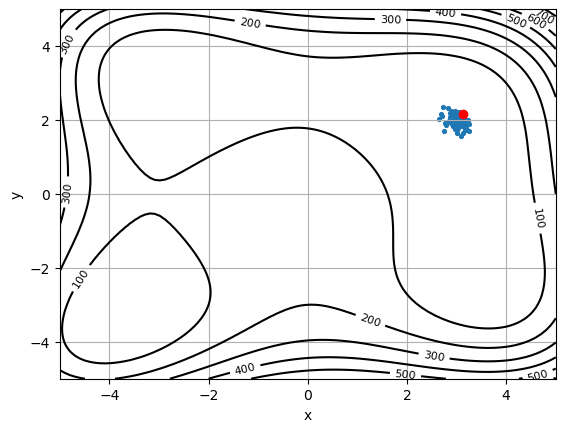

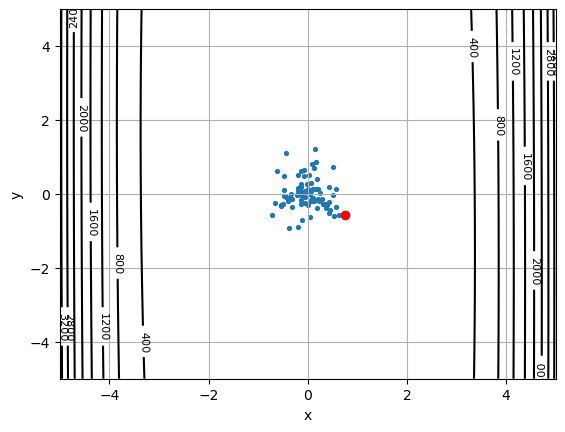

Epoch: 27 Best individual: [ 2.92539134  1.62665272  0.25298282 -0.07041216], F(bestIndividual)=2.8253459336846336


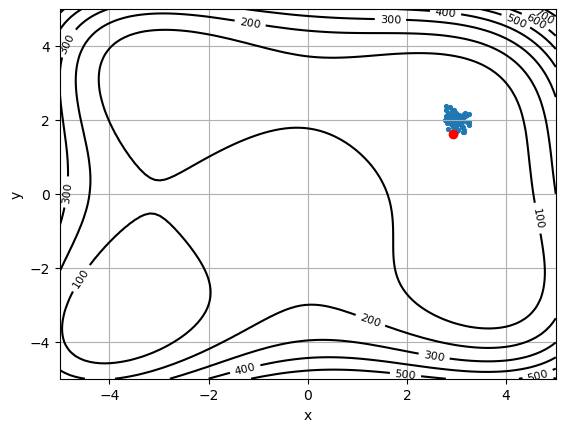

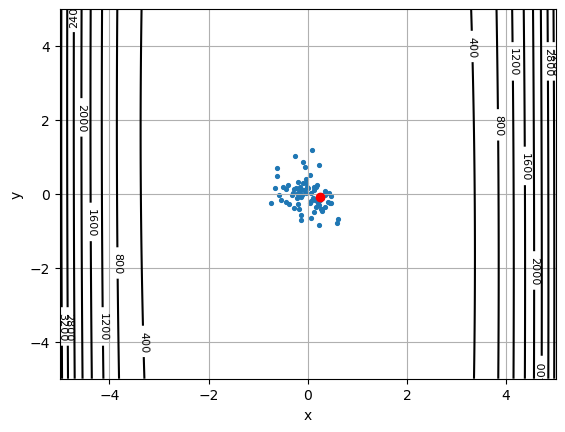

All time Best individual: [ 3.00028861  1.98432745 -0.04237505  0.09000088], F(bestIndividual)=0.011938749993548775


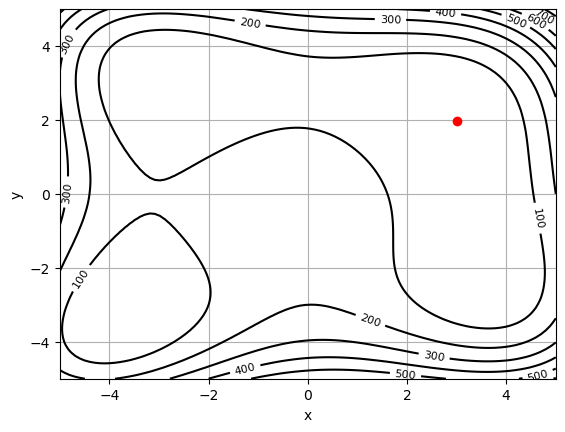

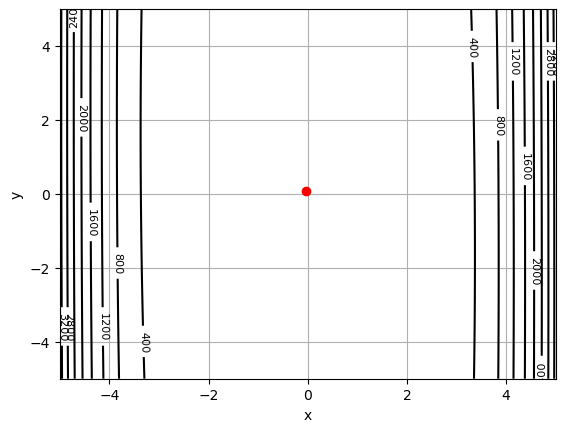

In [132]:
j = 3
D = [-5,5]
size = 80
startingPopulation = generateValuesAroundPoint(size, [-0.3,-0.9], 0.8)
x2 = np.random.uniform(D[0], D[1], size)
y2 = np.random.uniform(-5, 5, size)
startingPopulation = np.concatenate((startingPopulation, np.array([x2,y2]).T), axis=1)
startingPopulation = bringPopulationToBoundries(startingPopulation, D)
epochs, bestIndividual = evolutionAlgorithm(j*10, size, 0.8, 0.1, D)
populationGrades = [gradePopulation(epoch,D) for epoch in epochs]
X1,Y1,Z1 = getPlotVariables(-5,5,f1)
X2,Y2,Z2 = getPlotVariables(-5,5,f2)

for i in range(len(epochs)//(j)):
    # additionalPoints = findBestIndividuals(epochs[i*j], size, D)
    additionalPoints = epochs[i*j]
    additionalPointsF1 = np.array([[item[0], item[1]] for item in additionalPoints])
    additionalPointsF2 = np.array([[item[2], item[3]] for item in additionalPoints])
    currentBestIndividual = additionalPoints[0]

    print(f'Epoch: {i*j} Best individual: {currentBestIndividual}, F(bestIndividual)={sumF1F2(currentBestIndividual)}')



    draw2DPlot(X1,Y1,Z1,currentBestIndividual[0:2],additionalPointsF1[1:-1])
    draw2DPlot(X2,Y2,Z2,currentBestIndividual[2:4],additionalPointsF2[1:-1])

print(f'All time Best individual: {bestIndividual}, F(bestIndividual)={sumF1F2(bestIndividual)}')
draw2DPlot(X1,Y1,Z1,bestIndividual[0:2])

draw2DPlot(X2,Y2,Z2,bestIndividual[2:4])

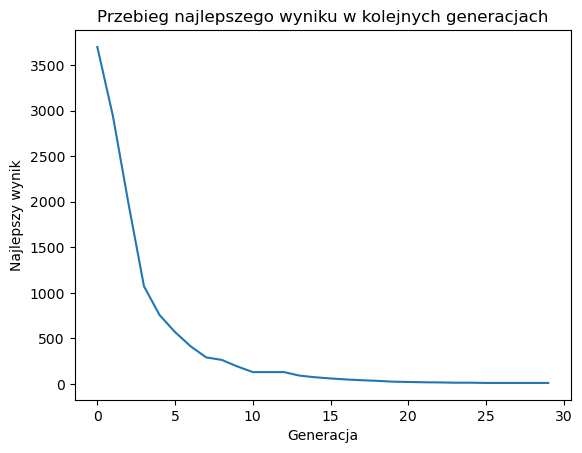

In [133]:
# Wektor wyników w danej generacji
wyniki_danej_generacji = [gradePopulation(findBestIndividuals(item,30,D),D) for item in epochs]

plt.plot(wyniki_danej_generacji)
plt.xlabel('Generacja')
plt.ylabel('Najlepszy wynik')
plt.title('Przebieg najlepszego wyniku w kolejnych generacjach')
plt.show()